In [78]:
# Some code ref : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import argparse
import time
from copy import deepcopy # Add Deepcopy for args

# Generating Dataset

In [79]:
# Receive data, split them into even-length sequences, and return 
# data : any sequence data as a whole
# seq_len : length of small sequences to split 'data' into
def generate_seq_data(data, seq_len):
    # split a univariate sequence into samples
    def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    # choose a number of time steps
    n_steps = seq_len
    # split into samples
    X, y = split_sequence(data, n_steps)
    # reshape from [batch_size, seq_len] into [seq_len, batch_size, features]
    n_features = 1
    X = np.swapaxes(X,0,1)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    return X, y

# Model Define

In [80]:
# Simple many-to-one LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_first = False): 
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim

        self.layer = nn.LSTM(input_size = self.input_dim, hidden_size = self.hid_dim, batch_first = batch_first)
        self.FC = nn.Linear(self.hid_dim, self.output_dim)

    def forward(self, x):
        output, (h, c) = self.layer(x)
        y = self.FC(output[-1]) # many-to-one
        return y

# Model training

In [81]:
def experiment(data, args):  
    net = LSTM(args.input_dim, args.output_dim, args.hid_dim, args.batch_first)

    criterion = nn.MSELoss() # regression 문제이므로
    optimizer = optim.SGD(net.parameters(), lr = args.lr, weight_decay=args.l2 if args.l2 is not None else 0)
    
    train_losses = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        optimizer.zero_grad() 

        input_x, true_y = generate_seq_data(data, args.seq_len)
        input_x = torch.Tensor(input_x).float()
        true_y = torch.Tensor(true_y).float()

        pred_y = net(input_x)
        print(input_x.shape, pred_y.shape, true_y.shape)
        print(torch.squeeze(pred_y)[:5])
        print(true_y[:5])

        loss = criterion(torch.squeeze(pred_y), true_y)
        print(f'Epoch : {epoch} - loss : {loss.item()/len(true_y)}\n')
        train_losses.append(loss.item()/len(true_y))

        loss.backward()
        optimizer.step()


    # Prediction
    # Give first starting sequence and let the model generate rest 
    print("--Prediction start--")
    n_steps = args.seq_len
    n_features = 1
    test_xaxis = np.arange(0, 10*np.pi, 0.1)
    def test_function(x):
        return np.cos(x)
    true_y = test_function(test_xaxis)
    
    # start with initial n values, rest will be predicted
    test_y = true_y[:n_steps]
    for i in range(len(test_xaxis) - n_steps):
        net_input = test_y[i : i + n_steps]
        net_input = net_input.reshape((n_steps, 1, n_features))
        net_input = torch.Tensor(net_input).float()
        y = net(net_input)
        test_y = np.append(test_y, y.view(-1).item())

    return net, test_xaxis, test_y, true_y, train_losses

# Experiment

torch.Size([10, 3132, 1]) torch.Size([3132, 1]) torch.Size([3132])
tensor([0.0797, 0.0799, 0.0773, 0.0715, 0.0742], grad_fn=<SliceBackward>)
tensor([0.6378, 0.8628, 1.3795, 0.7719, 0.8523])
Epoch : 0 - loss : 0.00019876657013387667

torch.Size([10, 3132, 1]) torch.Size([3132, 1]) torch.Size([3132])
tensor([0.0781, 0.0783, 0.0759, 0.0705, 0.0731], grad_fn=<SliceBackward>)
tensor([0.6378, 0.8628, 1.3795, 0.7719, 0.8523])
Epoch : 1 - loss : 0.00019811090001049017

torch.Size([10, 3132, 1]) torch.Size([3132, 1]) torch.Size([3132])
tensor([0.0766, 0.0768, 0.0746, 0.0697, 0.0720], grad_fn=<SliceBackward>)
tensor([0.6378, 0.8628, 1.3795, 0.7719, 0.8523])
Epoch : 2 - loss : 0.00019746565879685365

torch.Size([10, 3132, 1]) torch.Size([3132, 1]) torch.Size([3132])
tensor([0.0751, 0.0754, 0.0734, 0.0688, 0.0710], grad_fn=<SliceBackward>)
tensor([0.6378, 0.8628, 1.3795, 0.7719, 0.8523])
Epoch : 3 - loss : 0.00019683035169067967

torch.Size([10, 3132, 1]) torch.Size([3132, 1]) torch.Size([3132])
t

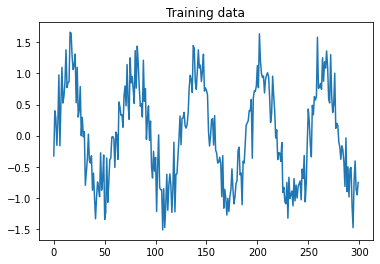

In [82]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.input_dim = 1
args.output_dim = 1 
args.hid_dim = 20
args.seq_len = 10

# ====== Regularization ======= #
args.l2 = 0

# ====== Optimizer & Training ====== #
args.lr = 1e-2
args.epoch = 200
args.batch_first = False


# ====== Experiment Variable ====== #
# define input sequence
xaxis = np.arange(-50*np.pi, 50*np.pi, 0.1)

train_seq = np.sin(xaxis)

include_noise = True # Introduce noise into training data
if include_noise : 
    noise = np.random.normal(0, 0.3, len(train_seq)) # Gaussian noise : mu, std
    train_seq += noise

plt.plot(train_seq[:300])
plt.title("Training data")

net, inp_x, gen_y, true_y, train_losses = experiment(train_seq, deepcopy(args))

mode = None #"single", "double", None
if mode == "single" :
    name_var1 = 'hid_dim'
    list_var1 = [10, 20, 30, 50, 100]

    loss_df = pd.DataFrame(columns=['loss', name_var1])
    df = pd.DataFrame(columns=['input_x', 'gen_y', 'true_y', name_var1])
    for var1 in list_var1:
        setattr(args, name_var1, var1)
        print(args)
        
        ts = time.time()
        _, input_x, gen_y, true_y, train_losses = experiment(train_seq, deepcopy(args))
        te = time.time()
        print(f'Elapsed time : {te-ts}s\n')

        newDf = pd.DataFrame({"input_x":input_x, "gen_y":gen_y, "true_y":true_y, name_var1:[var1]*len(gen_y)})
        df = pd.concat([df, newDf])
        loss_df = pd.concat([loss_df, pd.DataFrame({"loss":train_losses, name_var1:[var1]*len(train_losses)}) ])

# Visualization

## Single variable grid-layout

In [83]:
# Visualize result of grid layout
if mode == "single":
    # plot prediction
    g = sns.FacetGrid(df, col=name_var1)
    def dual_plot(input_x, gen_y, true_y, **kwargs):
        plt.plot(input_x, true_y, label = "true")
        plt.plot(input_x, gen_y, label = "generated")
        plt.legend(loc='upper left')
    g.map(dual_plot, 'input_x', 'gen_y', 'true_y')

    # plot loss
    loss_g = sns.FacetGrid(loss_df, col=name_var1)
    loss_g.map(plt.plot, 'loss')

## Single experiment prediction

--Prediction start--


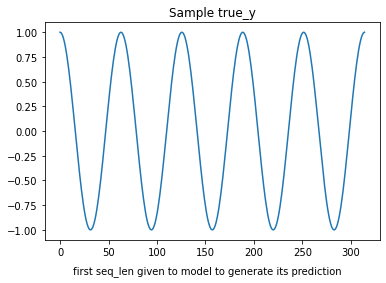

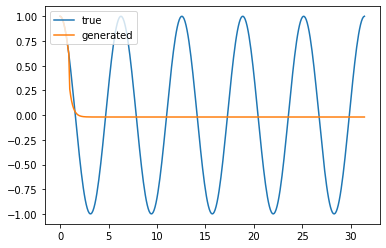

In [85]:
# Start wave prediction with single trained model 
if mode == None:
    print("--Prediction start--")
    n_steps = args.seq_len
    n_features = 1
    test_xaxis = np.arange(0, 10*np.pi, 0.1)
    def test_function(x):
        return np.cos(x) # + np.random.normal(0, 0.1, len(x)) # Gaussian noise : mu, std
    true_y = test_function(test_xaxis)

    fig = plt.figure()
    plt.plot(true_y)
    plt.title("Sample true_y")
    fig.text(.5, .01, "first seq_len given to model to generate its prediction", ha='center')
    
    # start with initial n values, rest will be predicted
    test_y = true_y[:n_steps]

    for i in range(len(test_xaxis) - n_steps):
        net_input = test_y[i : i + n_steps]
        net_input = net_input.reshape((n_steps, 1, n_features))
        net_input = torch.Tensor(net_input).float()
        y = net(net_input)
        test_y = np.append(test_y, y.view(-1).item())

    plt.figure()
    plt.plot(test_xaxis, true_y, label = "true")
    plt.plot(test_xaxis, gen_y, label = "generated")
    plt.legend(loc='upper left')